In [1]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ## Beautiful Plots :)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import re
import operator
import datetime
from collections import Counter
from nltk import ngrams
from utils import *
import gc

In [3]:
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics

In [4]:
class Random_Acts_Of_Pizza(object):
    """
    This class takes in a dataframe from "Random Acts Of Pizza"
    and creates a set of features for each requests present in
    the data. The features can be explicitly accessed with the 
    help of methods of this class.
    """
    
    def __init__(self,dataframe):
        """
        The input is a dataframe. We have explicitly used
        data provided from the Kaggle competition named as
        Random Acts Of Pizza.
        Link : https://www.kaggle.com/c/random-acts-of-pizza/data
        """
        self.df = dataframe
    
    def __str__(self):
        return str(self.df.info())
    
    def get_narrative(self,col,narrative):
        """
        Takes in input as the column and a lexicon for
        the narrative. The lexicon is in the form of a 
        dictionary where key in the narrative and value
        is a string containing all words relating to the
        narrative.
        Outputs a list containing narrative score for
        each request
        """
        request_narrative,narration = [],[]
        for request in self.df[col]:
            word_count = {'Money':0,'Job':0,'Student':0,'Family':0,'Craving':0}
            n = 0
            for word in request.split():
                for lexicon in narrative:
                    if word in narrative[lexicon]:
                        word_count[lexicon] += 1
            narration.append(max(word_count.iteritems(), key=operator.itemgetter(1))[0])
        print 'Use get_dummies to encode the features as binary'
        return narration
    
    def get_politeness(self,col,polite_words):
        """
        Takes in input as the column for which politeness
        needs to be calculated.
        Output is a list of floats for each request where
        each float corresponds to the politeness score for
        each request.
        """
        count,politeness = 0,[]
        for request in self.df[col]:
            count += 1
            request_ngrams = []
            for grams in ngrams(request.split(),3):
                request_ngrams.append(' '.join(grams))
            for grams in ngrams(request.split(),2):
                request_ngrams.append(' '.join(grams))
            request_words = set(request.split())
            request_ngrams = set(request_ngrams)
            num = len(request_words.intersection(set(polite_words))) +\
            len(request_ngrams.intersection(set(polite_words)))
            try:
                politeness.append(float(num)/len(request_words))
            except:
                politeness.append(0.0)
        print 'Total Number of request parsed: ',count
        return politeness
    
    def get_length(self,col):
        """
        Takes input as the column name(for the request)
        Outputs the length 
        """
        return [len(x.split()) for x in self.df[col]]
    
    def get_karma(self):
        """
        Calculate the karma score for each user of the
        RAOP.
        Output is a list of karma score for each requester.
        """
        karma = self.df['requester_upvotes_plus_downvotes_at_request']+\
        self.df['requester_upvotes_plus_downvotes_at_retrieval']
        return karma
    
    def get_score(self):
        """
        Calculates the score of each user of RAOP.
        Output is a list of score for each user.
        """
        score = self.df['requester_upvotes_minus_downvotes_at_request']+\
        self.df['requester_upvotes_minus_downvotes_at_retrieval']
        return score
    
    def get_evidentiality(self,col):
        """
        We count the occur- rences of http links, image links,
        and “proof”/“prove”
        Returns a list of number of urls for each request.
        """
        urls = []
        for text in self.df[col]:
            url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
            urls.append(len(url))
        return urls
    
    def get_complexity(self,col):
        """
        Takes input as the column of request and calculate
        the complexity score given by Flesch-Kincaid Grade 
        Level.
        Returns a list of complexity score for each request.
        """
        grade_level = []
        syl = set(['a','e','i','o','u'])
        for text in self.df[col]:
            sent_cnt = len(text.split('.'))
            words = re.sub("["+'!"#$%&\'()*+.,-/:;<=>?@[\\]^_`{|}~'+"]", " ", text).split()
            syl_count = 0
            for word in words:
                for letter in list(word):
                    if letter in syl:
                        syl_count += 1
            grade_level.append(Flesch_reading_ease(total_sentences = sent_cnt,total_words = len(words),\
                                                   total_sylabls=syl_count))
        return grade_level
    
    def spell_check_score(self,col):
        """
        We further use a spell-checker to identify misspelled 
        words in the request text [10]. In other contexts 
        (e.g. Kickstarter), spelling errors have been found to
        have a negative impact on funding success.
        
        Input is the column of request.
        Returns a list of spelling check score for each
        request
        """
        spell_errors = []
        for text in self.df[col]:
            spl_err = 0
            words = re.sub("["+'!"#$%&\'()*+.,-/:;<=>?@[\\]^_`{|}~'+"]", " ", text).split()
            if len(words):
                for word in words:
                    if correction(word)!= word: 
                        spl_err += 1
                spell_errors.append(float(spl_err)/len(words))
            else:
                spell_errors.append(0)
        return spell_errors
    
    def first_half_of_month(self,col):
        """
        Input is the column containing the timestamp
        Returns the day of the timestamp for a request
        """
        return [datetime.datetime.fromtimestamp(int(timestamp)).day \
                for timestamp in self.df[col]]
    
    def get_popularity(self,col):
        """
        Input is the column containing the total upvotes
        the request got at time of retrieval
        """
        return self.df[col]
    
    def get_usersimilarity(self , col):
        store = []
        """
        Input:
            column containing username of requesters
        Output:
            score : Their similarity score based on interactions in common
            subreddits between requester and  giver user
        """
        for i in self.df[col]:
            ls = list(self.df[self.df.requester_username == i].requester_subreddits_at_request)
            giver_ = list(self.df[self.df.requester_username == i].giver_username_if_known)
            score = 0
            if len(ls[0]) and giver_[0] != "N/A":
                for j in ls[0]:
                    a = get_post_from_subreddit_by_user(i , j)
                    b = get_post_from_subreddit_by_user(giver_[0] , j)
                    if a != 0 and b != 0:
                        score += (a+b)
            store.append(score)
        return store
    def get_age(self):
        """
        Input : void
        Output : A panda series having the age of account
        (present in dataset already)
        """
        return df['requester_days_since_first_post_on_raop_at_request']
    
    def get_activity(self):
        """
        Input : void
        Output : A panda series having the activity of account
        (present in dataset already)
        """
        return self.df['requester_number_of_subreddits_at_request']
    
    def train_model(self,data,model,response_col,scoring='roc_auc',cv=5):
        """
        Input:
            data : new morphed data frame
            model : the model on which data is to be trained.
            response_col : name of column to be used as
            response
            cv : number of cross validation scores
            scoring : method of scoring
        Output:
            score : k-fold cv score for the model
        """
        global id_,df_
        data_copy = data.copy()
        y = data_copy.pop(response_col)
        scores = cross_val_score(model,data_copy,y,scoring=scoring,cv=cv)
        model.fit(data_copy , y)
        #y = df_.pop(response_col)
        pred = model.predict(data_copy)
        pred = [1 if i else 0 for i in pred]
        print "Accuracy = " , metrics.accuracy_score(y,pred)
        #print predictions
        submission = pd.DataFrame({ 'request_id': id_,'requester_received_pizza': pred})
        submission.to_csv("submission.csv", index=False)
        del data_copy # Dataframe may be too large
        gc.collect() # Explicitly collecting the garbage
        return scores.mean()

    

In [5]:
df = pd.read_json('train.json')
df_ = pd.read_json('test.json')
print df_.shape
#df = df.append(df_)
requests = 'request_text_edit_aware'
df.shape
idx = list(df_['request_id'])
idx1=list(df['request_id'])

#len(set(idx) - set(idx1))

(1631, 17)


In [6]:
df.head(2)

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,0,1,0,t3_l25d7,0,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,...,False,[],0,1,0,1,None,nickylvst,1317852607,1317849007
1,N/A,2,5,0,t3_rcb83,0,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,...,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1332652424,1332648824


In [7]:
raop = Random_Acts_Of_Pizza(df)
print raop

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 32 columns):
giver_username_if_known                                 4040 non-null object
number_of_downvotes_of_request_at_retrieval             4040 non-null int64
number_of_upvotes_of_request_at_retrieval               4040 non-null int64
post_was_edited                                         4040 non-null int64
request_id                                              4040 non-null object
request_number_of_comments_at_retrieval                 4040 non-null int64
request_text                                            4040 non-null object
request_text_edit_aware                                 4040 non-null object
request_title                                           4040 non-null object
requester_account_age_in_days_at_request                4040 non-null float64
requester_account_age_in_days_at_retrieval              4040 non-null float64
requester_days_since_first_post_on_raop_at_reque

In [8]:
leak_  = [ 1 if i != None else 0 for i in df['requester_user_flair']]
id_ = list(df['request_id'])

In [9]:
fr = open('similarity.txt' , 'r')
store = []
while True:
    try:
        a = int(fr.readline())
        store.append(a)
    except:break
df_ = pd.read_csv('sentiment.csv')
sentiments = list(df_['sentiment'])[:4040]
print len(sentiments)
ls = [1 if i != "N/A" else 0 for i in df['giver_username_if_known']]

4040


In [10]:
## Calculating all the features
narrative = raop.get_narrative(col=requests,narrative=narrative)
df['narrative_topics'] = narrative
df = pd.get_dummies(df,columns=['narrative_topics'])
df['politeness'] =  raop.get_politeness(col=requests,polite_words=polite_words)
df['request_length'] = raop.get_length(requests)
df['karma'] = raop.get_karma()
df['scores'] = raop.get_score()
df['trust'] = raop.get_evidentiality(requests)
df['complexity'] = raop.get_complexity(requests)
df['popularity'] = raop.get_popularity('number_of_upvotes_of_request_at_retrieval' )
df['age'] = raop.get_age()
df['similarity'] = store
df['giver'] = ls
df['sentiment'] = sentiments
df['sentiment'] = df['sentiment'].fillna(0)
df['first_half_of_month'] = pd.Series(raop.first_half_of_month('unix_timestamp_of_request')) < 15
df['activity'] = raop.get_activity()

Use get_dummies to encode the features as binary
Total Number of request parsed:  4040


In [11]:
if not os.path.isfile('spellCheck.csv'):
    df['spell_check_score'] = raop.spell_check_score(requests)
    df['spell_check_score'].to_csv('spellCheck.csv')
    print df.spell_check_score.head(2)
else:
    print 'File exists...'

File exists...


In [12]:
shap = dict()
f_ = open('shapleyvalue.txt' , 'r')
val = f_.readlines()
for i in val:
    a , b = map(str , i.split(' '))
    b = float(b)
    shap[a] = b
    #print a , b
#print shap
ls_ = [ shap[i] for i in df['requester_username']]
idx = 0
for i in df['giver_username_if_known']:
    if i != 'N/A':
        ls_[idx] += (shap[i] if i in shap else 0.000)
    idx += 1
df['shapley'] = ls_

f_1 = open('degree.txt' , 'r')
val = f_1.readlines()
in_ , out_ = dict() , dict()
for i in val:
    a , b, c = map(str , i.split())
    b = int(b); c = int(c)
    in_[a]  = b
    out_[a] = c
in_ls  =  [ in_[i] for i in df['requester_username']]
out_ls =  [ out_[i] for i in df['requester_username']]
df['in_degree'] = in_ls
df['out_degree'] = out_ls
#df['leaky'] = leak_

In [13]:
req_features = [
 #'request_id ',
 'complexity',
 'first_half_of_month',
 'karma',
 'narrative_topics_Craving',
 'narrative_topics_Family',
 'narrative_topics_Job',
 'narrative_topics_Money',
 'narrative_topics_Student',
 'politeness',
 'popularity',
 'request_length',
 'scores',
 'trust',
 'requester_received_pizza',
 'similarity',
 'sentiment',
 'giver',
 'activity',
 'age',
 'in_degree',
 'out_degree',
 'shapley'
]


In [14]:
df_new = df.drop([col for col in df.columns if col not in req_features],axis=1)
df_new.head(2)

,requester_received_pizza,narrative_topics_Craving,narrative_topics_Family,narrative_topics_Job,narrative_topics_Money,narrative_topics_Student,politeness,request_length,karma,scores,...,popularity,age,similarity,giver,sentiment,first_half_of_month,activity,shapley,in_degree,out_degree
0,False,0,1,0,0,0,0.0,67,1,1,...,1,0.0,0,0,2.250,True,0,0.0,0,0
1,False,0,0,0,1,0,0.0,16,11284,4292,...,5,0.0,0,0,0.375,False,12,0.0,0,0


In [20]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1')
score = raop.train_model(df_new,model=model,response_col='requester_received_pizza',cv=2)

Accuracy =  0.820792079208


In [21]:
print 'ROC Score: {}'.format(score*100)

ROC Score: 80.2266653103


COMPARISON MODELS 

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier   
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

classifiers=[
    (LogisticRegression(penalty='l1'),"LR"),
    (KNeighborsClassifier(5),"KNC"),
    (SVC(),'SVC'),
    (QuadraticDiscriminantAnalysis(),'QDA'),
    (RandomForestClassifier(max_depth=50, n_estimators=10, max_features=1),'RFC'),
    (AdaBoostClassifier(),'ADC'),
    (SGDClassifier(),'SGDC'),
    (DecisionTreeClassifier(max_depth=5),'DTC'),
    (xgboost.XGBClassifier(learning_rate=0.1),'XGB'),
    (LinearDiscriminantAnalysis(),'LDA'),
    (GaussianNB(),'GNB')
]

In [18]:
score_ , names = [] , []
for model,name in classifiers:
    score = raop.train_model(df_new,model=model,response_col='requester_received_pizza')
    score_.append(score)
    names.append(name)
    print 'ROC Score: {}'.format(score*100) , name

Accuracy =  0.820792079208
ROC Score: 80.2796050354 LR
Accuracy =  0.791336633663
ROC Score: 57.2566636594 KNC
Accuracy =  0.992574257426
ROC Score: 57.9297752114 SVC
Accuracy =  0.264603960396
ROC Score: 64.418828183 QDA
Accuracy =  0.983415841584
ROC Score: 76.9341796046 RFC
Accuracy =  0.827475247525
ROC Score: 81.7707514073 ADC
Accuracy =  0.75396039604
ROC Score: 44.6992148956 SGDC
Accuracy =  0.827227722772
ROC Score: 80.857147362 DTC
Accuracy =  0.841089108911
ROC Score: 82.8074378832 XGB
Accuracy =  0.822524752475
ROC Score: 80.3158237345 LDA
Accuracy =  0.80297029703
ROC Score: 74.709762504 GNB


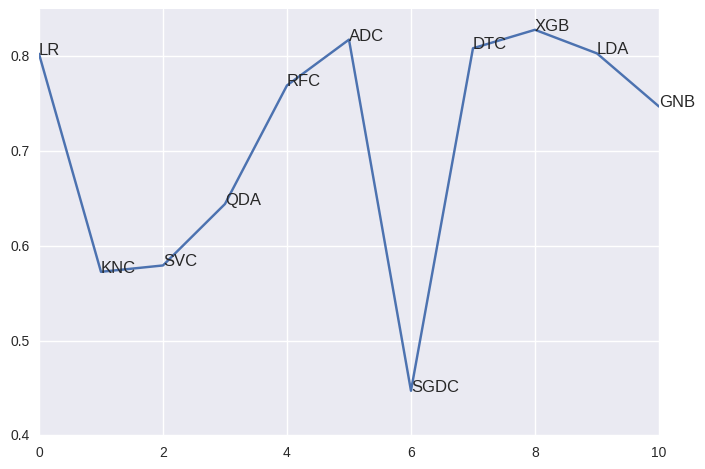

In [19]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
A = score_[:]
plt.plot(A)
for i, label in enumerate(names):
    plt.text(i,A[i], label) 
plt.show()